## Building a RNN to classify text using pre-trained embeddings

We will create a very small dataset with 10 sentences, 8 for training and 2 for test, to perfrom classification.

**Note** that these embeddings are trained on general sentences. If you need more specific embeddings you must train them using your examples. In this case we have not enough examples to do so.



In [1]:
from tensorflow import keras
import pandas as pd
import re
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional, Flatten
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
%matplotlib inline

## Load the data
Usually data is stored in csv files (use of pandas). In this case we manually create sentences to perform a rudimental sentiment analisys. -> si cerca di capire se la frase ha uno stato d'animo 'buono' o 'cattivo'.

In [2]:
traind = {'sentence': [
      'Quella pizza era buona', #sentiment buono
      'Questo gelato fa schifo', #sentiment cattivo
      'Il film non mi piace molto',
      'La sua nuova canzone non mi piace',
      'Adoro il gelato',
      'Quella canzone mi piace molto',
      'Che brutto!',
      'Mi piace!'
], 'sentiment': [
      'buono',
      'cattivo',
      'cattivo',
      'cattivo',
      'buono',
      'buono',
      'cattivo',
      'buono'
]}

testd = {'sentence': [
      'La zuppa non mi piace per niente',
      'Questa zuppa sembra ottima'
], 'sentiment': [
      'cattivo',
      'buono'
]}

allsentences= [
      'Quella pizza era buona',
      'Questo gelato fa schifo',
      'Il film non mi piace molto',
      'La sua nuova canzone non mi piace',
      'Adoro il gelato',
      'Quella canzone mi piace molto',
      'Che brutto!',
      'Mi piace!',
      'La zuppa non mi piace per niente',
      'Questa zuppa sembra ottima'
]

#Il dataset è inserito in un dataframe di pandas (più semplice accedere a righe e colonne)
train_data = pd.DataFrame(data=traind)
test_data = pd.DataFrame(data=testd)

print(train_data)
print(test_data)

                            sentence sentiment
0             Quella pizza era buona     buono
1            Questo gelato fa schifo   cattivo
2         Il film non mi piace molto   cattivo
3  La sua nuova canzone non mi piace   cattivo
4                    Adoro il gelato     buono
5      Quella canzone mi piace molto     buono
6                        Che brutto!   cattivo
7                          Mi piace!     buono
                           sentence sentiment
0  La zuppa non mi piace per niente   cattivo
1        Questa zuppa sembra ottima     buono


Now we have to clean textual data by removing capital letters and undesired characters such as punctuation.

In [3]:
#Pulizia delle frasi (lettere grandi, punti...)
#PRIMO MODO DI PULIRE
train_data['sentence'] = train_data['sentence'].apply(lambda x: x.lower()) # to lowercase
train_data['sentence'] = train_data['sentence'].apply((lambda x: re.sub('[^a-z\s]', '', x))) # remove all characters that are not in a-z

test_data['sentence'] = test_data['sentence'].apply(lambda x: x.lower()) # to lowercase
test_data['sentence'] = test_data['sentence'].apply((lambda x: re.sub('[^a-z\s]', '', x))) # remove all characters that are not in a-z

#SECONDO MODO DI PULIRE
for i in range(len(allsentences)):
  allsentences[i] = allsentences[i].lower()
  allsentences[i] = re.sub('[^a-z\s]', '', allsentences[i])

print(train_data)
print(test_data)
print(allsentences)

                            sentence sentiment
0             quella pizza era buona     buono
1            questo gelato fa schifo   cattivo
2         il film non mi piace molto   cattivo
3  la sua nuova canzone non mi piace   cattivo
4                    adoro il gelato     buono
5      quella canzone mi piace molto     buono
6                         che brutto   cattivo
7                           mi piace     buono
                           sentence sentiment
0  la zuppa non mi piace per niente   cattivo
1        questa zuppa sembra ottima     buono
['quella pizza era buona', 'questo gelato fa schifo', 'il film non mi piace molto', 'la sua nuova canzone non mi piace', 'adoro il gelato', 'quella canzone mi piace molto', 'che brutto', 'mi piace', 'la zuppa non mi piace per niente', 'questa zuppa sembra ottima']


The sentences must be split in order to get the single words. To do so we can use the Tokenizer.

The Tokenizer class of keras allows you to tokenize, taking a text and mapping each word into a sequence of integers. Using this class we tokenize the phrases of the dataset.

In [4]:
#DIMENSIONE DEL VOCABOLARIO (v)
vocab_size = 28 # number of different words, we have 28 different words so we can set a number greater or equal to 28

#Creazione del tokenizzattore -> le suddivido sullo spazio
tokenizer = Tokenizer(num_words=vocab_size, split=' ')
#tokenizer.fit_on_texts(train_data['sentence'].values) # <= ATTENTION HERE!
#Se non faccio in questo modo allenando train e poi test ottengo lo stesso numero per parole diverse
#quindi: prima va ADDESTRATO su tutte le frasi (se lo faccio solo su una non riconosce delle parole o gli assegna lo stesso numero)
tokenizer.fit_on_texts(allsentences) # <= ATTENTION HERE!

X_train = tokenizer.texts_to_sequences(train_data['sentence'].values)
X_train = pad_sequences(X_train)  # Padding to make sequences of same length
#raffigurazione onehot su y
Y_train = pd.get_dummies(train_data['sentiment']).values

print('train')
print(X_train)
print(Y_train) #onehot encoding

# same for test data
#tokenizer.fit_on_texts(test_data['sentence'].values)
X_test = tokenizer.texts_to_sequences(test_data['sentence'].values)
X_test = pad_sequences(X_test)
Y_test = pd.get_dummies(test_data['sentiment']).values

print('test')
print(X_test)
print(Y_test)

train
[[ 0  0  0  4 11 12 13]
 [ 0  0  0 14  5 15 16]
 [ 0  6 17  3  1  2  7]
 [ 8 18 19  9  3  1  2]
 [ 0  0  0  0 20  6  5]
 [ 0  0  4  9  1  2  7]
 [ 0  0  0  0  0 21 22]
 [ 0  0  0  0  0  1  2]]
[[1 0]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [1 0]]
test
[[ 8 10  3  1  2 23 24]
 [ 0  0  0 25 10 26 27]]
[[0 1]
 [1 0]]


Tokenization must be prepared considering the whole dataset (or at least a part of it containing all the words contained in the dataset). Otherwise you will get different tokenization (if you fit it considering test and training set separatedly) or tokenization not considering all the words.


In [5]:
#Decido la dimensione degli embedding
embed_dim = 300 # size of Word2Vec embeddings
lstm_out = 5 

### Create the model
We use two new layers:

- **Embedding**: Turns positive integers (indexes) into dense vectors of fixed size. eg. [[4], [20]] -> [[0.25, 0.1], [0.6, -0.2]]. This layer can only be used as the first layer in a model.

- **LSTM**: Implements the Long Short-Term Memory layer.


 `Embedding(input_dim, output_dim, embeddings_initializer='uniform', embeddings_regularizer=None, activity_regularizer=None, embeddings_constraint=None, mask_zero=False, input_length=None)`

- input_dim: int > 0. Size of the vocabulary, i.e. maximum integer index + 1.
- output_dim: int >= 0. Dimension of the dense embedding.
- embeddings_initializer: Initializer for the embeddings matrix 

LSTM has many parameters, some of them are:
- units: Positive integer, dimensionality of the output space.
- activation: Activation function to use (see activations). Default: hyperbolic tangent (tanh). If you pass None, no activation is applied (ie. "linear" activation: a(x) = x).



In [6]:
model = Sequential()
model.add(Embedding(vocab_size, embed_dim, input_length=X_train.shape[1]))
model.add(LSTM(lstm_out, activation='tanh', dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='softmax')) #classificazione (buon anche essere fatta con un neurone cambiando la rappresentazione)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 7, 300)            8400      
                                                                 
 lstm (LSTM)                 (None, 5)                 6120      
                                                                 
 dense (Dense)               (None, 2)                 12        
                                                                 
Total params: 14,532
Trainable params: 14,532
Non-trainable params: 0
_________________________________________________________________


In [7]:
history = model.fit(X_train, Y_train, epochs=50, 
                    batch_size=100, verbose=2, shuffle=True)



Epoch 1/50
1/1 - 10s - loss: 0.6875 - accuracy: 0.6250 - 10s/epoch - 10s/step
Epoch 2/50
1/1 - 0s - loss: 0.6819 - accuracy: 0.7500 - 15ms/epoch - 15ms/step
Epoch 3/50
1/1 - 0s - loss: 0.6730 - accuracy: 0.7500 - 19ms/epoch - 19ms/step
Epoch 4/50
1/1 - 0s - loss: 0.6693 - accuracy: 0.6250 - 18ms/epoch - 18ms/step
Epoch 5/50
1/1 - 0s - loss: 0.6457 - accuracy: 0.8750 - 21ms/epoch - 21ms/step
Epoch 6/50
1/1 - 0s - loss: 0.6468 - accuracy: 0.7500 - 19ms/epoch - 19ms/step
Epoch 7/50
1/1 - 0s - loss: 0.6252 - accuracy: 0.8750 - 19ms/epoch - 19ms/step
Epoch 8/50
1/1 - 0s - loss: 0.6345 - accuracy: 0.8750 - 19ms/epoch - 19ms/step
Epoch 9/50
1/1 - 0s - loss: 0.6146 - accuracy: 0.8750 - 17ms/epoch - 17ms/step
Epoch 10/50
1/1 - 0s - loss: 0.6045 - accuracy: 0.8750 - 16ms/epoch - 16ms/step
Epoch 11/50
1/1 - 0s - loss: 0.5929 - accuracy: 0.8750 - 17ms/epoch - 17ms/step
Epoch 12/50
1/1 - 0s - loss: 0.5834 - accuracy: 0.8750 - 17ms/epoch - 17ms/step
Epoch 13/50
1/1 - 0s - loss: 0.5751 - accuracy: 0.

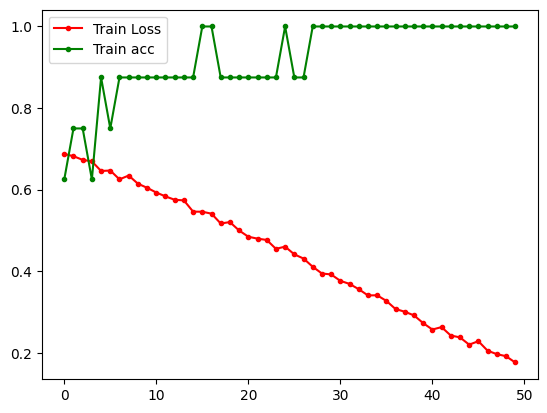

In [8]:
fig, ax = plt.subplots()
ax.plot(history.history["loss"],'r', marker='.', label="Train Loss")
ax.plot(history.history["accuracy"],'g', marker='.', label="Train acc")
ax.legend()

#Chiaro overfitting (non c'è validation)

In [9]:
model.predict(X_test)

1/1 [==============================] - 1s 1s/step


array([[0.24840398, 0.751596  ],
       [0.6140001 , 0.38599986]], dtype=float32)

In [10]:
results = model.evaluate(X_test, Y_test)
print('test loss, test acc:', results)

1/1 [==============================] - 1s 1s/step - loss: 0.3867 - accuracy: 1.0000
test loss, test acc: [0.386658251285553, 1.0]


Let's try another network.

We try to use a Bidirectional LSTM, were the state is passed both forward and backward.

**Bidirectional** is a bidirectional wrapper for RNNs.

In [11]:
#Creazione di una rete bidirezionale
model1 = Sequential()
model1.add(Embedding(vocab_size, embed_dim, input_length=X_train.shape[1]))
model1.add(Bidirectional(LSTM(lstm_out, activation='tanh', dropout=0.2, recurrent_dropout=0.2)))
model1.add(Dense(2, activation='softmax'))
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model1.summary()

history = model1.fit(X_train, Y_train, epochs=50, 
                    batch_size=100, verbose=2, shuffle=True)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 7, 300)            8400      
                                                                 
 bidirectional (Bidirectiona  (None, 10)               12240     
 l)                                                              
                                                                 
 dense_1 (Dense)             (None, 2)                 22        
                                                                 
Total params: 20,662
Trainable params: 20,662
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
1/1 - 18s - loss: 0.6951 - accuracy: 0.5000 - 18s/epoch - 18s/step
Epoch 2/50
1/1 - 0s - loss: 0.6873 - accuracy: 0.7500 - 18ms/epoch - 18ms/step
Epoch 3/50
1/1 - 0s - loss: 0.6789 - accuracy: 0.6250 - 20ms/epoch - 20ms/step
Epoch 4/50
1

In [12]:
model1.predict(X_test)

1/1 [==============================] - 1s 1s/step


array([[0.2264473, 0.7735527],
       [0.6343155, 0.3656845]], dtype=float32)

In [13]:
results1 = model1.evaluate(X_test, Y_test)
print('test loss, test acc:', results1)

1/1 [==============================] - 2s 2s/step - loss: 0.3560 - accuracy: 1.0000
test loss, test acc: [0.355985164642334, 1.0]


We can also add more LSTM layers.

To do so we must fix the parameter `return_sequences` to True in all the LSTM except the last.

In [14]:
#Aumento la rete
model2 = Sequential()
#Embedding addestrato insieme alla rete (altrimenti trainble= False nel caso in cui
# siano già stati addestrati)
model2.add(Embedding(vocab_size, embed_dim, input_length=X_train.shape[1]))
model2.add(Bidirectional(LSTM(lstm_out, return_sequences=True, # this option must be used if we have more LSTM
                             activation='tanh', dropout=0.2, recurrent_dropout=0.2)))
model2.add(LSTM(lstm_out, return_sequences=True))
model2.add(Bidirectional(LSTM(lstm_out, return_sequences=True, # this option must be used if we have more LSTM
                             activation='tanh', dropout=0.2, recurrent_dropout=0.2)))
model2.add(LSTM(lstm_out))
model2.add(Dense(2, activation='softmax'))
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model2.summary()

history = model2.fit(X_train, Y_train, epochs=50, 
                    batch_size=100, verbose=2, shuffle=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 7, 300)            8400      
                                                                 
 bidirectional_1 (Bidirectio  (None, 7, 10)            12240     
 nal)                                                            
                                                                 
 lstm_3 (LSTM)               (None, 7, 5)              320       
                                                                 
 bidirectional_2 (Bidirectio  (None, 7, 10)            440       
 nal)                                                            
                                                                 
 lstm_5 (LSTM)               (None, 5)                 320       
                                                                 
 dense_2 (Dense)             (None, 2)                

In [15]:
model2.predict(X_test)

1/1 [==============================] - 6s 6s/step


array([[0.29184166, 0.70815843],
       [0.6026056 , 0.3973945 ]], dtype=float32)

In [16]:
results2 = model2.evaluate(X_test, Y_test)
print('test loss, test acc:', results2)

1/1 [==============================] - 6s 6s/step - loss: 0.4258 - accuracy: 1.0000
test loss, test acc: [0.4257899522781372, 1.0]


### Use of pretrained Embeddings
With larger datasets, the performances could be really poor due to embeddings not well trained.

We can try to use pre-trained embeddings.

To do so we must download the pre-trained model, there are model for [Word2Vec](https://code.google.com/archive/p/word2vec/), [GloVe](https://nlp.stanford.edu/projects/glove/), and many others. For each model there may be also many different versions tailored on different languages.

Once loaded, we can create an embedding_matrix from the pre-trained models and load this matrix as the weights of the Embedding layer

In [17]:
#embedding matrix scaricata
#poi gli embedding possono essere usati cosi come sono: trainable = False
#oppure possono essere ulteriormente addestrati: trainable = True
model2 = Sequential()
model.add(Embedding(vocab_size, embed_dim, weights=[embedding_matrix], # Here we use the pre-trained embeddings
                    input_length=X.shape[1], trainable=False))
model2.add(Bidirectional(LSTM(lstm_out, return_sequences=True, # this option must be used if we have more LSTM
                             activation='tanh', dropout=0.2, recurrent_dropout=0.2)))
model2.add(LSTM(lstm_out, return_sequences=True))
model2.add(LSTM(lstm_out))
model2.add(Dense(2, activation='softmax'))

NameError: name 'embedding_matrix' is not defined

What changes her is the `Embedding` layer, where we initialize the weights with those of the pre-trained model (`weights=[embedding_matrix]`).
Moreover, we can decide whether to tune these weigths during the training or keep them fixed by using the parameter `trainable`.